In [1]:
import pandas as pd
import numpy as np
# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
import sklearn


In [256]:
# read data
df = pd.read_csv("data.csv")

# Data Inspection
The data is scrapped from PUBG's developer's website, with randomly generated match samples from three gaming platforms. Each match stores the match and player statistics. Squad is the most popular match type, followed by duo and solo. To better analyze the data, we normalized some columns as needed, and removed outliers that does not fit.



In [125]:
df.shape,df.columns

((173087, 23),
 Index(['playerId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
        'headshotKills', 'heals', 'killPlace', 'kills', 'killStreaks',
        'longestKill', 'matchDuration', 'matchType', 'revives', 'rideDistance',
        'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys',
        'walkDistance', 'weaponsAcquired', 'winPlace'],
       dtype='object'))

In [ ]:
## Match level inspection

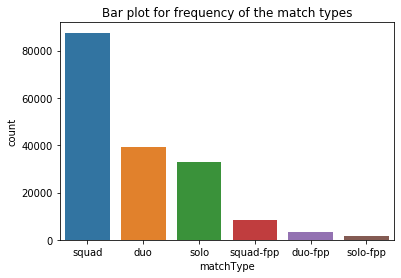

In [4]:
sns.countplot(df.matchType, order = df.matchType.value_counts().index)
plt.title("Bar plot for frequency of the match types")
plt.show()

## Outlier Detection for Illegal Matches

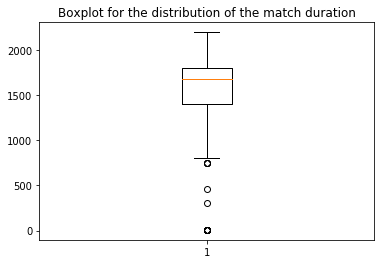

In [5]:
plt.boxplot(df.matchDuration)
# plt.annotate('median', xy=(1, df.matchDuration.median()), xytext=(1.5, 10),
#             arrowprops=dict(facecolor='black', shrink=0.05),fontsize = 14
#             )
plt.title("Boxplot for the distribution of the match duration")
plt.show()

There are some outliers in the match duration. With the median around 1600s and some matches only last for 8 seconds, we suspect some of the matches go wrong that could either caused by loading error or bug. 

In [6]:
# check for the games under normal length of duration
display(len(df[(df['matchDuration'] < 500)]['matchDuration']))
df[(df['matchDuration'] < 500)]['matchDuration']

12

87149     456
91096       8
96030       8
96187     309
99417       8
102400      8
110025      8
118365      8
118366      8
118367      8
127609      8
135300      8
Name: matchDuration, dtype: int64

In [7]:
# delete those data with match duratino shorter than 10 seconds
df = df.drop(index = df[(df['matchDuration'] < 10)].index).reset_index().drop(columns = ['index'])

In [8]:
df.shape

(173077, 23)

In [9]:
# check if exist illegal match where no players joined
df[(df.groupby("matchId")['playerId'].transform(len) == 0)]

,playerId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,...,matchType,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlace


# Feature Engineering

In [257]:
# player statistics are by match level. So we normalize the statistics by the number of players jonied.
df['playersJoined'] = df.groupby("matchId")['playerId'].transform(len)

In [258]:
# normalize feature winPlacePerc for the winning place by players joined for each match
df['winPlacePerc'] = df.groupby(df['matchId'])['winPlace'].transform(lambda x: (x.max()-x)/(x.max()-x.min()))
df['winPlacePerc'].fillna(0,inplace = True)

In [259]:
# normalize selected killing statistics by players joined for each match
df['killsNorm'] = df['kills']*((100-df['playersJoined'])/100 + 1)
df['damageDealtNorm'] = df['damageDealt']*((100-df['playersJoined'])/100 + 1)

In [260]:
# combine distances together and cerate feature totalDistance
df['totalDistance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance']
# create feature killsWithoutMoving
df['killsWithoutMoving'] = ((df['kills'] > 0) & (df['totalDistance'] == 0))

In [261]:
# create headshot_rate feature
df['headshot_rate'] = df['headshotKills'] / df['kills']
df['headshot_rate'] = df['headshot_rate'].fillna(0)

In [262]:
# create label assist and revives
df['assist_revives'] = df['assists'] + df['revives']

In [263]:
# create label boosts and heals
df['boost_heals'] = df['boosts'] + df['heals']

In [264]:
df.shape # 7 more features than original

(173087, 32)

In [265]:
df.columns

Index(['playerId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'kills', 'killStreaks',
       'longestKill', 'matchDuration', 'matchType', 'revives', 'rideDistance',
       'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys',
       'walkDistance', 'weaponsAcquired', 'winPlace', 'playersJoined',
       'winPlacePerc', 'killsNorm', 'damageDealtNorm', 'totalDistance',
       'killsWithoutMoving', 'headshot_rate', 'assist_revives', 'boost_heals'],
      dtype='object')

In [266]:
# drop unuseful columns
df = df.drop(columns = ['winPlace','damageDealt','DBNOs','killPlace','revives','assists','boosts','heals'])


# Outlier Detection for Cheaters/Zombies/Anomalies of the game

In [267]:
# check palyers who do not move at all
df[(df['totalDistance'] == 0)].shape

(5929, 24)

In [268]:
# check players who kills without moving
display(df[df['killsWithoutMoving'] == True].shape)
df[df['killsWithoutMoving'] == True].iloc[:,2:]

(7, 24)

,headshotKills,kills,killStreaks,longestKill,matchDuration,matchType,rideDistance,roadKills,swimDistance,teamKills,...,weaponsAcquired,playersJoined,winPlacePerc,killsNorm,damageDealtNorm,totalDistance,killsWithoutMoving,headshot_rate,assist_revives,boost_heals
4509,0,1,1,4.016906,1359,squad-fpp,0.0,0,0.0,0,...,1,97,0.114286,1.03,191.68300,0.0,True,0.0,1,0
44615,1,1,1,4.161036,1355,squad-fpp,0.0,0,0.0,0,...,1,91,0.038462,1.09,109.00000,0.0,True,1.0,0,0
125712,0,1,1,0.976856,1711,solo,0.0,0,0.0,0,...,0,98,0.144330,1.02,149.73599,0.0,True,0.0,0,0
153319,0,1,1,3.264551,1399,solo,0.0,0,0.0,0,...,1,98,0.051546,1.02,102.00000,0.0,True,0.0,0,0
157851,0,1,1,8.294130,1480,solo,0.0,0,0.0,0,...,1,97,0.020619,1.03,103.00000,0.0,True,0.0,0,0
163443,0,1,1,2.155670,1480,solo,0.0,0,0.0,0,...,1,99,0.010204,1.01,100.99999,0.0,True,0.0,0,0
171101,0,1,1,18.472420,1469,duo,0.0,0,0.0,0,...,1,90,0.000000,1.10,110.00000,0.0,True,0.0,0,0


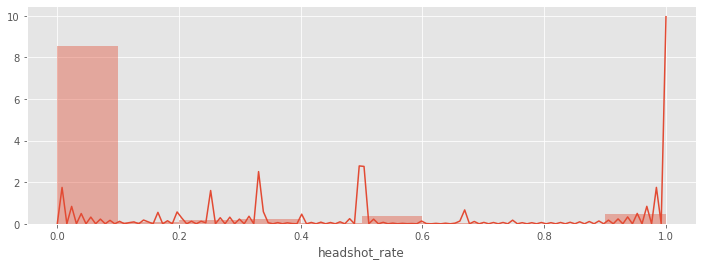

In [269]:
# Plot the distribution of headshot_rate
plt.figure(figsize=(12,4))
sns.distplot(df['headshot_rate'], bins=10)
plt.show()

According to this headshot rate distribution, there is an anomaly peak at 1.0  where all the kills are headshot kills. 

In [270]:
df['kills'].describe()

count    173087.000000
mean          0.880846
std           1.472751
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          32.000000
Name: kills, dtype: float64

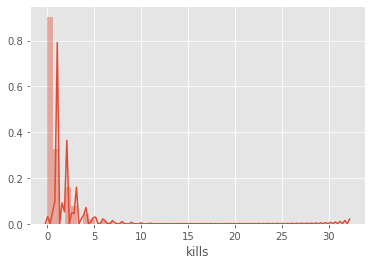

In [271]:
sns.distplot(df['kills'])
plt.show()

In [272]:
# Players who made a minimum of 5 kills and have a headshot_rate of 100%
display(df[(df['headshot_rate'] >= 1.0) & (df['kills'] >= 5)].shape)
df[(df['headshot_rate'] >= 1.0) & (df['kills'] >= 5)].iloc[:,2:]

(5, 24)

,headshotKills,kills,killStreaks,longestKill,matchDuration,matchType,rideDistance,roadKills,swimDistance,teamKills,...,weaponsAcquired,playersJoined,winPlacePerc,killsNorm,damageDealtNorm,totalDistance,killsWithoutMoving,headshot_rate,assist_revives,boost_heals
5810,5,5,5,1.294081,1795,squad,0.0000,0,0.0000,0,...,4,94,0.166667,5.30,530.000000,811.4638,False,1.0,0,0
8606,5,5,2,111.846954,1345,squad,0.0000,0,0.0000,0,...,3,96,0.916667,5.20,812.769204,3891.8857,False,1.0,1,8
29354,6,6,2,123.928280,1599,squad,1317.5952,0,0.0000,0,...,5,92,1.000000,6.48,1035.612292,4645.3342,False,1.0,2,17
108920,6,6,2,152.975810,1744,solo,0.0000,0,0.0000,0,...,5,98,0.867347,6.12,478.152438,4258.8850,False,1.0,0,1
141977,6,6,6,6.176190,1891,squad,0.0000,0,209.3323,0,...,5,98,0.655172,6.12,819.583362,4085.5935,False,1.0,0,0


Since the mean of kills is 0.88 and the distribution is very right skewed, having 5 kills is already pretty high. But this may not be the best metrics to indicate whether the player is a cheater, causing some false positives for very good players.

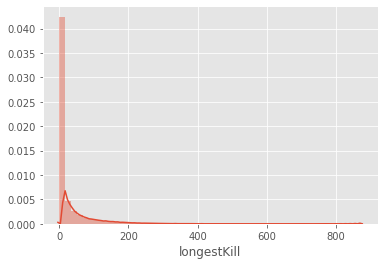

In [273]:
sns.distplot(df['longestKill'])
plt.show()

In [274]:
print(df[(df.longestKill > 400)].shape)
df[(df.longestKill > 400)].describe()

(143, 24)


,headshotKills,kills,killStreaks,longestKill,matchDuration,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,playersJoined,winPlacePerc,killsNorm,damageDealtNorm,totalDistance,headshot_rate,assist_revives,boost_heals
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,0.846154,3.419580,1.377622,464.433308,1799.272727,3067.449773,0.013986,3.031895,0.048951,0.048951,2488.843543,5.783217,93.216783,0.797905,3.673147,404.479965,5559.325211,0.215451,0.895105,7.783217
std,1.323183,2.538194,0.566733,71.338509,133.055118,2646.877407,0.117845,13.223293,0.216524,0.216524,876.549187,1.906770,6.596136,0.154361,2.782644,314.778537,2559.198069,0.288323,1.161066,6.669396
min,0.000000,1.000000,1.000000,400.631960,1326.000000,0.000000,0.000000,0.000000,0.000000,0.000000,872.041000,2.000000,61.000000,0.222222,1.010000,0.000000,1073.703900,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,413.144785,1724.000000,688.538270,0.000000,0.000000,0.000000,0.000000,1892.194850,4.500000,91.000000,0.708333,1.095000,164.744887,3625.229180,0.000000,0.000000,3.000000
50%,0.000000,3.000000,1.000000,445.923000,1818.000000,2771.462000,0.000000,0.000000,0.000000,0.000000,2375.844000,6.000000,95.000000,0.819149,3.060000,301.062798,5384.032200,0.000000,1.000000,6.000000
75%,1.000000,5.000000,2.000000,488.669980,1880.000000,4812.838750,0.000000,0.000000,0.000000,0.000000,2951.982900,7.000000,97.000000,0.919184,5.175000,580.941557,7181.412883,0.333333,1.000000,11.000000
max,9.000000,14.000000,4.000000,872.467960,2139.000000,11460.742000,1.000000,97.578350,1.000000,1.000000,5385.906000,11.000000,100.000000,1.000000,14.420000,1648.358466,14296.947000,1.000000,5.000000,44.000000


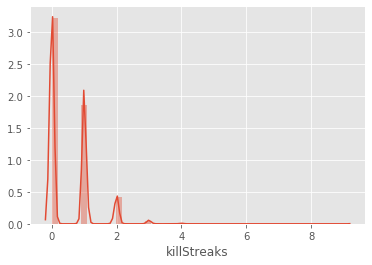

In [275]:
sns.distplot(df['killStreaks'])
plt.show()

In [276]:
print(df[(df.killStreaks > 6)].shape)
df[(df.killStreaks > 6)].iloc[:,2:]

(2, 24)


,headshotKills,kills,killStreaks,longestKill,matchDuration,matchType,rideDistance,roadKills,swimDistance,teamKills,...,weaponsAcquired,playersJoined,winPlacePerc,killsNorm,damageDealtNorm,totalDistance,killsWithoutMoving,headshot_rate,assist_revives,boost_heals
50235,9,10,9,17.898462,1374,squad,0.0,0,0.0,0,...,4,95,0.576923,10.5,1143.30468,431.09082,False,0.900000,0,0
124483,10,14,7,97.403120,1733,solo,0.0,0,0.0,0,...,6,95,0.872340,14.7,1450.03509,3661.09720,False,0.714286,0,6


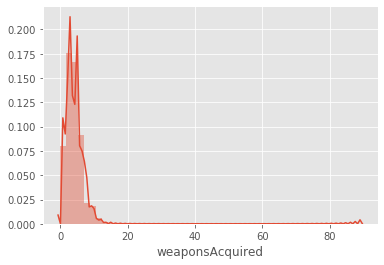

In [277]:
sns.distplot(df.weaponsAcquired)
plt.show()

In [278]:
display(df[(df.weaponsAcquired > 60)].shape)
df[(df.weaponsAcquired > 60)].iloc[:,2:]

(6, 24)

,headshotKills,kills,killStreaks,longestKill,matchDuration,matchType,rideDistance,roadKills,swimDistance,teamKills,...,weaponsAcquired,playersJoined,winPlacePerc,killsNorm,damageDealtNorm,totalDistance,killsWithoutMoving,headshot_rate,assist_revives,boost_heals
39341,0,0,0,0.0,1704,squad,1578.2256,0,0.0,0,...,64,86,0.391304,0.0,0.000000,2753.7185,False,0.0,5,1
52397,0,0,0,0.0,1807,solo,0.0000,0,0.0,0,...,76,19,1.000000,0.0,325.399538,0.0000,False,0.0,0,0
64162,0,0,0,0.0,1227,solo,0.0000,0,0.0,0,...,67,9,0.000000,0.0,0.000000,0.0000,False,0.0,0,1
98747,0,0,0,0.0,1804,solo,0.0000,0,0.0,0,...,69,11,1.000000,0.0,187.110000,0.0000,False,0.0,0,29
136675,0,0,0,0.0,1806,solo,0.0000,0,0.0,0,...,89,19,1.000000,0.0,32.580000,0.0000,False,0.0,0,0
155651,0,0,0,0.0,1807,solo,0.0000,0,0.0,0,...,68,18,0.000000,0.0,3.640000,0.0000,False,0.0,0,0


# Clustering

## K-means cluster


In [279]:
df.columns

Index(['playerId', 'matchId', 'headshotKills', 'kills', 'killStreaks',
       'longestKill', 'matchDuration', 'matchType', 'rideDistance',
       'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys',
       'walkDistance', 'weaponsAcquired', 'playersJoined', 'winPlacePerc',
       'killsNorm', 'damageDealtNorm', 'totalDistance', 'killsWithoutMoving',
       'headshot_rate', 'assist_revives', 'boost_heals'],
      dtype='object')

In [280]:
# prepare data
# drop columns not useful for clustering players
df_train = df
df_train = df.drop(columns = ['playerId', 'matchId','matchType', 'killsWithoutMoving','playersJoined',
                             'kills','matchDuration','teamKills','roadKills'])
df_train.shape

(173087, 15)

In [281]:
df_train.columns

Index(['headshotKills', 'killStreaks', 'longestKill', 'rideDistance',
       'swimDistance', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired',
       'winPlacePerc', 'killsNorm', 'damageDealtNorm', 'totalDistance',
       'headshot_rate', 'assist_revives', 'boost_heals'],
      dtype='object')

In [148]:
# normalize data on example level
import sklearn.preprocessing

df_train = sklearn.preprocessing.normalize(df_train, norm='l2', axis=1, copy=True, return_norm=False)

In [35]:
# import model
from sklearn.cluster import KMeans

"""
TODO:
takes too long, so just keep it here first.
"""
# find out the optimal clusters
# Sum_of_squared_distances = []
# K = range(1,15)
# for k in K:
#     km = KMeans(n_clusters=k, init='k-means++')
#     km = km.fit(df_train)
#     Sum_of_squared_distances.append(km.inertia_)

'\ntakes too long, so just keep it here first\n'

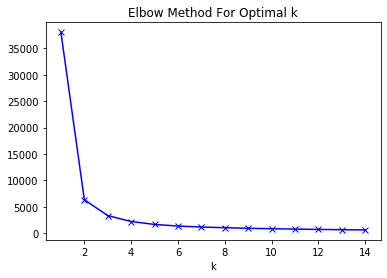

In [221]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.title('Elbow Method For Optimal k')
plt.show()

Initial assumption for k is **three**. From the EDA for predicting win place of each player, we know that the player's winning percentile is most positively correlated with three types of statistics: killing stats, items acquired, and running distances. With this assumption in mind, we rely on statistical method of sum of squared distances to support our assumption as above. And we confirm that our proof of concept for optimal k is 3.

In [283]:
kmeans = KMeans(n_clusters=3, init = 'k-means++').fit(df_train)
%time

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 4.05 µs


In [284]:
# create cluster label to original dataset
df['cluster'] = kmeans.labels_

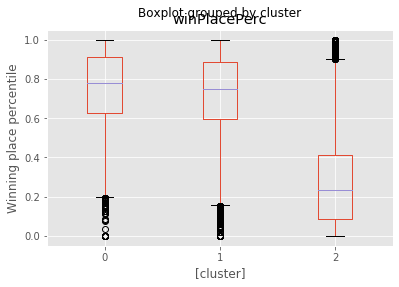

In [306]:
# winPlace
plt.style.use('ggplot')
pd.DataFrame(df.loc[:,['cluster','winPlacePerc']]).boxplot(by='cluster')
plt.ylabel("Winning place percentile")
plt.show()

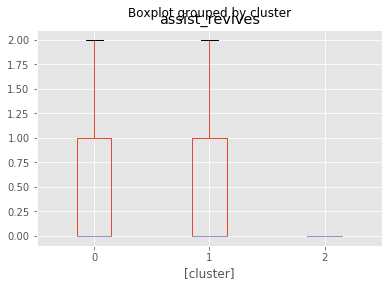

In [307]:
# assist revives
pd.DataFrame(df.loc[:,['cluster','assist_revives']]).boxplot(by='cluster', showfliers = False)
plt.show()

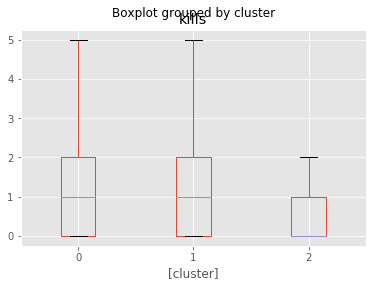

In [308]:
# kills
pd.DataFrame(df.loc[:,['cluster','kills']]).boxplot(by='cluster',showfliers = False)
plt.show()

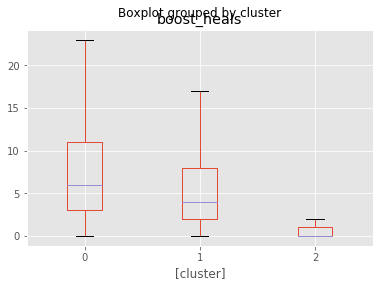

In [309]:
# heals boosts
pd.DataFrame(df.loc[:,['cluster','boost_heals']]).boxplot(by='cluster', showfliers = False)
plt.show()

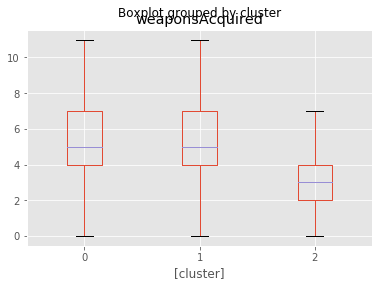

In [310]:
# distance
pd.DataFrame(df.loc[:,['cluster','weaponsAcquired']]).boxplot(by='cluster', showfliers = False)
plt.show()

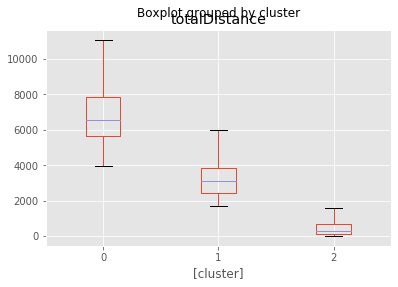

In [311]:
# distance
pd.DataFrame(df.loc[:,['cluster','totalDistance']]).boxplot(by='cluster', showfliers = False)
plt.show()

In [322]:
def clusterInsights(data,k):
    """
    get cluster insights about the relationship between critical player statistics and winning place.
    """
    clusters = data.groupby('cluster')
    
    # revives, assists and their correlation to winPlace
    plt.figure(figsize = (10,5))
    sns.boxplot(x=clusters.get_group(k)['assist_revives'],y=clusters.get_group(k)['winPlacePerc'])
    plt.show()    
    
    # kills
    plt.figure(figsize = (10,5))
    sns.boxplot(x=clusters.get_group(k)['kills'],y=clusters.get_group(k)['winPlacePerc'])
    plt.show()
    
    # kill streaks
    plt.figure(figsize = (10,5))
    sns.distplot(clusters.get_group(k)['killStreaks'])
    plt.show()

#     # headshot rate, check anomaly
#     plt.figure(figsize = (10,5))
#     sns.distplot(clusters.get_group(k)['heashot_rate'])
#     plt.show()
    
    # weapons acquired
    plt.figure(figsize = (10,5))
    sns.pointplot(x=clusters.get_group(k)['weaponsAcquired'],y=clusters.get_group(k)['winPlacePerc'])
    plt.show()
    
    # walking distance
    plt.figure(figsize = (10,5))
    sns.scatterplot(x=clusters.get_group(k)['walkDistance'],y=clusters.get_group(k)['winPlacePerc'])
    plt.show()
    
    # swimming distance
    plt.figure(figsize = (10,5))
    sns.scatterplot(x=clusters.get_group(k)['swimDistance'],y=clusters.get_group(k)['winPlacePerc'])
    plt.show()    

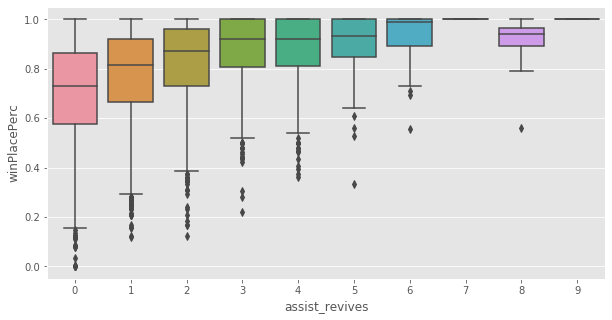

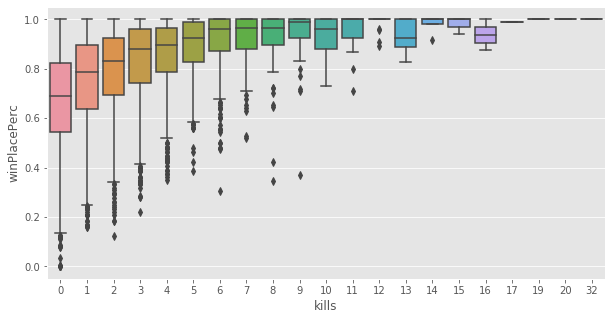

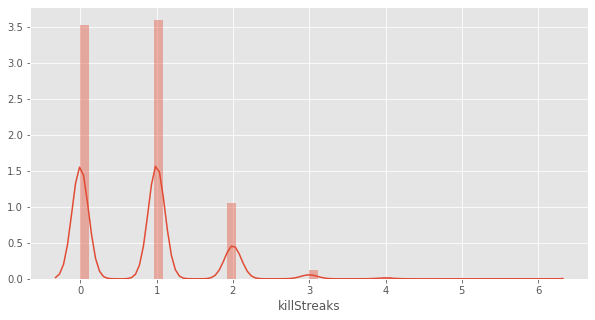

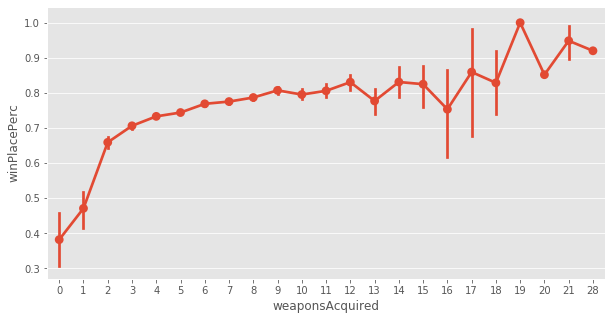

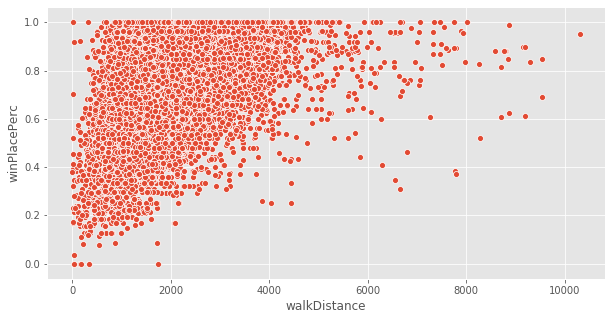

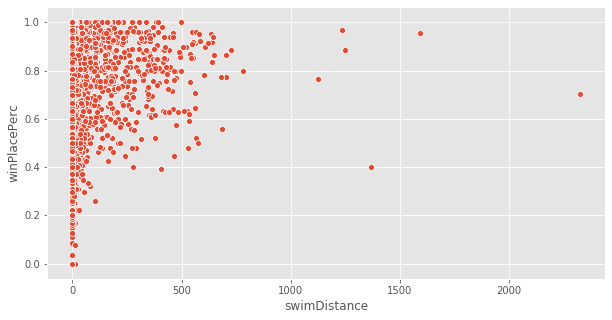

In [323]:
# cluster 1
clusterInsights(df,0)

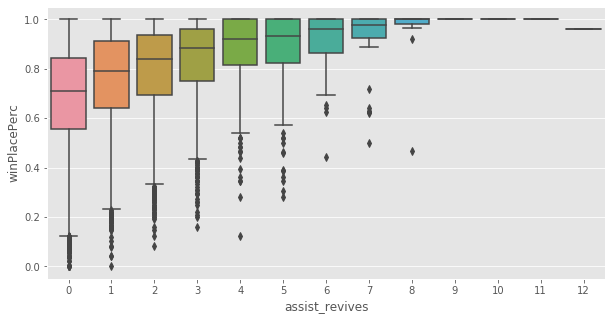

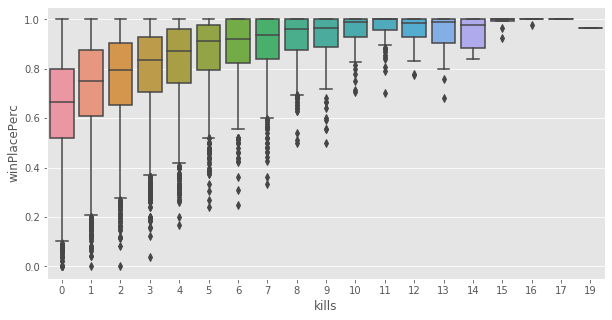

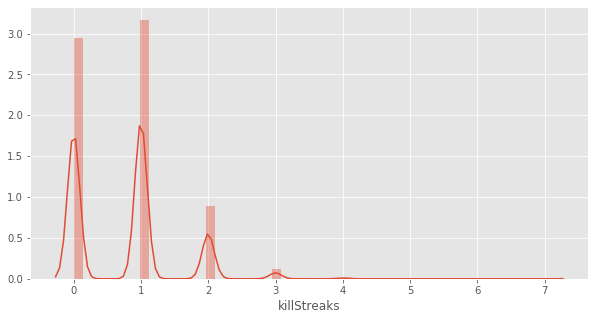

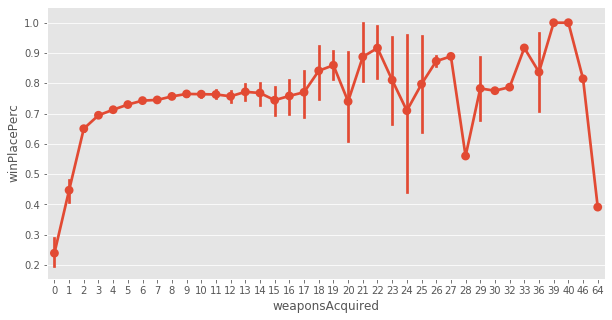

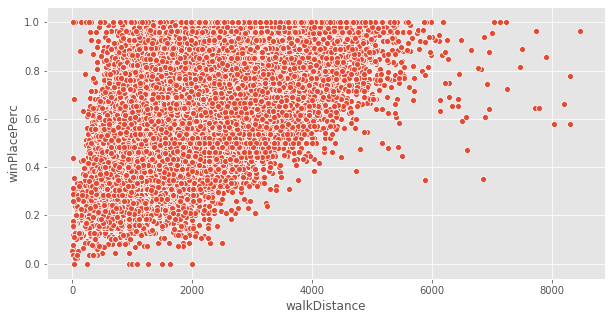

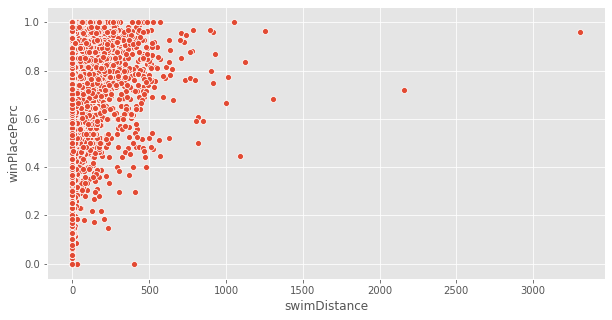

In [324]:
# cluster 2
clusterInsights(df,1)

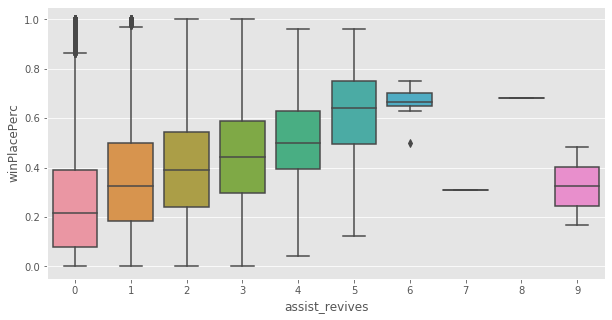

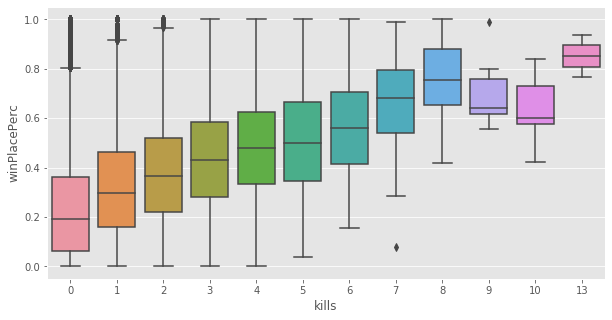

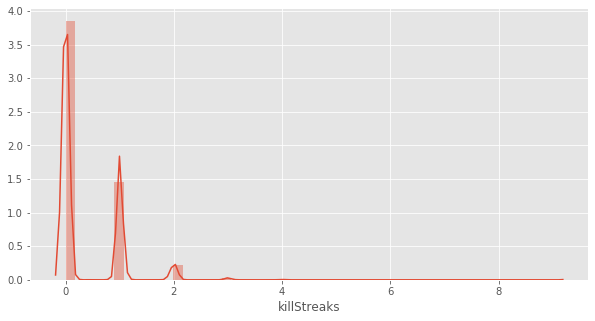

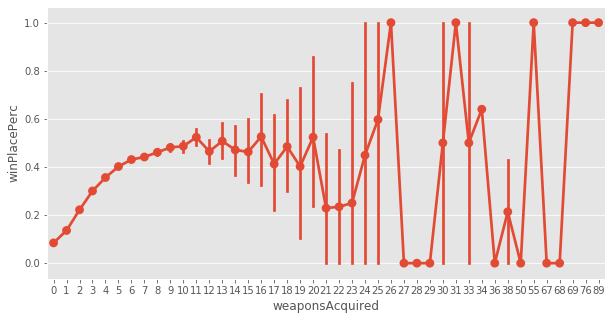

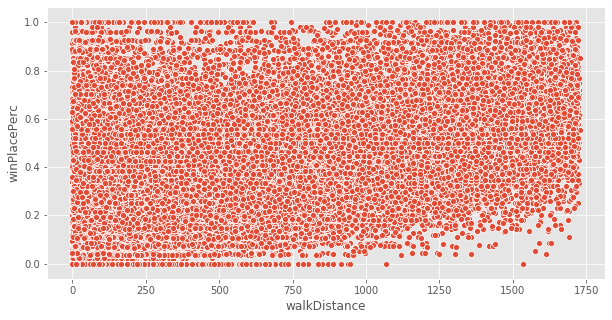

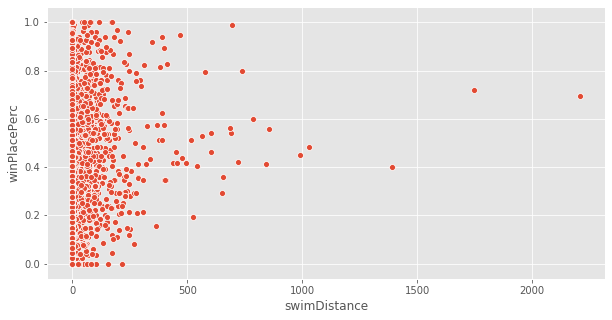

In [326]:
# cluster 3
clusterInsights(df,2)

# Anomaly Detection

In [ ]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
# An estimation of anomly population of the dataset (necessary for several algorithm)
# Calculate the number of outlier points. If the distance of points from cluster centroidis greater than 10% then 
# we classify the point as an outlier

In [235]:
# distances to all clusters
alldistances = kmeans.fit_transform(train)

In [236]:
alldistances.shape

(173077, 4)

In [239]:
# distance to the closest cluster
totalDistance = np.min(alldistances, axis=1)

In [241]:
totalDistance.shape

(173077,)

In [246]:
# create the distance from the closest cluster variable
df['distanceCluster'] = totalDistance

In [320]:
anomaly_fraction = 0.001 
number_of_anomalies = int(anomaly_fraction*len(df))
k = 4
anomalies_cluster = number_of_anomalies//k

lst_anomaly_index = list(df.sort_values(['cluster','distanceCluster'], ascending = False).groupby('cluster').head(anomalies_cluster).index)


In [321]:
# create anomaly label
dct_anomaly = {k:0 for k in range(len(df))}
for i in lst_anomaly_index:
    dct_anomaly[i] = 1

df['anomaly'] = dct_anomaly.values()
    

In [322]:
df[(df.anomaly) == 1].shape

(172, 23)

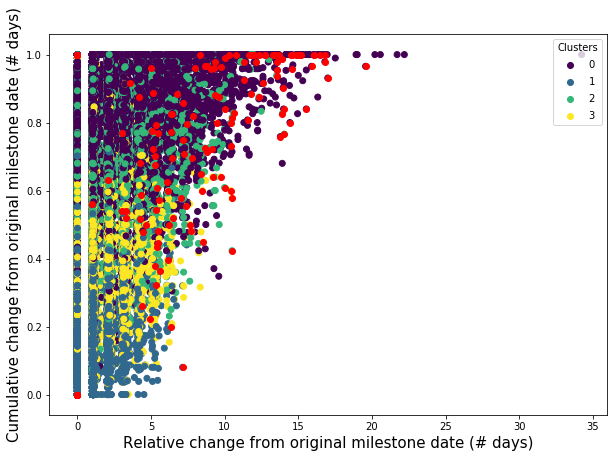

In [331]:
#Plot the clustering results based on FPD relative change in days and FPD Cumulative change in days
fig, ax = plt.subplots(figsize = (10,7))

anomaly_points = df[(df.anomaly) == 1]

scatter = plt.scatter(df.killsNorm, df.winPlacePerc, c = kmeans.labels_)
anomaly = plt.scatter(anomaly_points.killsNorm, anomaly_points.winPlacePerc, c = 'red')
legend1 = ax.legend(*scatter.legend_elements(),
            loc="upper right", title="Clusters")

# plt.xlabel("Player kills normalized by match players", fontsize = 15)
# plt.ylabel("Winning place percentile", fontsize = 15)
# plt.title("Clusters using Kmeans Clustering with Anomaly Poitns",fontsize = 18)


plt.xlabel("Relative change from original milestone date (# days)", fontsize = 15)
plt.ylabel("Cumulative change from original milestone date (# days)", fontsize = 15)
plt.show()

In [ ]:
# TODO:
# 1. GaussianMixture model
# 2. AD EDA from cluster analysis

In [211]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=1)
